In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr  6 14:02:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 27.3 MB/s 
     |████████████████████████████████| 181 kB 87.9 MB/s 
     |████████████████████████████████| 144 kB 80.8 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=444751b30541b2c1bc7f55a710bc10916c1749584c8ec28c8c2c49fc89e8fb66
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import wandb

try :
  from kaggle_secrets import UserSecretsClient
  user_secrets = UserSecretsClient()
  api_key = user_secrets.get_secret('wandb_api')
  wandb.login(key = api_key)
  anony = None
except :
  anony = 'must'
  print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet  your W&B access token from here: https://wandb.ai/authorize')


If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get  your W&B access token from here: https://wandb.ai/authorize


In [ ]:
wandb.login(key = '3425a29d2a1f74ea708343f8604ba4c9f3618c4f')

wandb: Currently logged in as: eunsungshin (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!pip install timm
!pip install faiss-gpu
!pip install optuna

In [ ]:
# augmentation
!pip install albumentations==0.4.6 # albumentation import 버젼 오류 있음. *(ToTensorV2) 
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from torch.optim import lr_scheduler
!pip install colorama
import os
import gc
import cv2
import math
import copy
import time
import random
import optuna

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import joblib
from tqdm import tqdm
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import StratifiedKFold

import timm

import faiss #similarity search


from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings('ignore')

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [ ]:
CONFIG = dict(seed = 2022,
              epochs = 300,
              img_size = 448,
              model_name = 'tf_efficientnet_b0_ns',
              num_classes = 15587,
              embedding_size = 512,
              pretrained = True,
              train_batch_size = 32,
              valid_batch_size = 64,
              learning_rate = 1e-5,
              scheduler= 'CosineAnnealingLR',
              min_lr = 1e-6,
              load_weight = '/content/drive/MyDrive/Colab Notebooks/Loss13.7009_epoch8.bin',
              T_max = 500,
              weight_decay = 1e-6,
              n_fold = 5,
              n_accumulate = 1,
              device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
              # GeM Hyperparameters
              p = 3,
              eps = 1e-6,
              # ArcFace Hyperparameters
              s = 30.0,
              m = 0.50,
              ls_eps = 0.0,
              easy_margin = False,
               )

In [ ]:

def set_seed(seed=42) :
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  # when running on the CuDNN backend, two further options must be set
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  # set a fixed value for the hash seed
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(CONFIG['seed'])

In [ ]:
ROOT_DIR = '/content/drive/MyDrive/Colab Notebooks'
TRAIN_DIR = '/content/drive/MyDrive/Colab Notebooks/resized_train_images'
TEST_DIR = '/content/drive/MyDrive/Colab Notebooks/resized_test_images'


In [ ]:
def get_train_file_path(id) :
  return f'{TRAIN_DIR}/{os.path.basename(id)}'

In [ ]:
df = pd.read_csv(f'{ROOT_DIR}/edit_train.csv')
df['file_path'] = df['image'].apply(get_train_file_path)
df.head()

,Unnamed: 0,image,species,individual_id,class,file_path
0,0,/content/drive/My Drive/Colab Notebooks/resize...,melon_headed_whale,cadddb1636b9,whale,/content/drive/MyDrive/Colab Notebooks/resized...
1,1,/content/drive/My Drive/Colab Notebooks/resize...,humpback_whale,1a71fbb72250,whale,/content/drive/MyDrive/Colab Notebooks/resized...
2,2,/content/drive/My Drive/Colab Notebooks/resize...,false_killer_whale,60008f293a2b,whale,/content/drive/MyDrive/Colab Notebooks/resized...
3,3,/content/drive/My Drive/Colab Notebooks/resize...,bottlenose_dolphin,4b00fe572063,dolphin,/content/drive/MyDrive/Colab Notebooks/resized...
4,4,/content/drive/My Drive/Colab Notebooks/resize...,humpback_whale,8e5253662392,whale,/content/drive/MyDrive/Colab Notebooks/resized...


In [ ]:
df.file_path[0]

'/content/drive/MyDrive/Colab Notebooks/resized_train_images/00021adfb725ed.jpg'

In [ ]:
encoder = LabelEncoder()
df['individual_id'] = encoder.fit_transform(df['individual_id'])


with open(f'{ROOT_DIR}/le.pkl', 'wb') as fp :
  joblib.dump(encoder, fp)


In [ ]:
skf = StratifiedKFold(n_splits = CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.individual_id)) :
  df.loc[val_, 'fold'] = fold

In [ ]:
class HappyWhaleDataset(Dataset) :
  def __init__(self, df, transforms = None) :
    self.df = df
    self.file_names = df['file_path'].values
    self.labels = df['individual_id'].values
    self.transforms = transforms

  def __len__(self) :
    return len(self.df)

  def __getitem__(self, index) :
    img_path = self.file_names[index]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = self.labels[index]

    if self.transforms :
      img = self.transforms(image = img)['image']

    return {
        'image' : img,
        'label' : torch.tensor(label, dtype = torch.long)
    }

In [ ]:
# Augmentations

data_transforms = {
    'train' : A.Compose([
                         A.Resize(CONFIG['img_size'], CONFIG['img_size']),
                         A.ShiftScaleRotate(shift_limit = 0.1,
                                            scale_limit = 0.15,
                                            rotate_limit = 60,
                                             p = 0.5),
                         A.HueSaturationValue(
                             hue_shift_limit = 0.2,
                             sat_shift_limit = 0.2,
                             val_shift_limit = 0.2,
                             p = 0.5
                         ),
                         A.RandomBrightnessContrast(
                             brightness_limit = (-0.1, 0.1),
                             contrast_limit = (-0.1, 0.1),
                             p = 0.5
                         ),
                         A.Normalize(
                             mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225],
                             max_pixel_value = 255.0, 
                             p = 1.0
                         ),
                         ToTensorV2()], p=1.0),
    'valid' : A.Compose([
                         A.Resize(CONFIG['img_size'], CONFIG['img_size']),
                         A.Normalize(
                             mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225],
                             max_pixel_value = 255.0,
                             p = 1.0
                         ),
                        ToTensorV2()], p = 1. )
                         
}

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class GeM(nn.Module) :
  def __init__(self, p = 3, eps = 1e-6) :
    super(GeM, self).__init__()
    self.p = nn.Parameter(torch.ones(1)*p)
    self.eps = eps
  def forward(self, x) :
    return self.gem(x, p = self.p, eps = self.eps)

  def gem(self, x, p = 3, eps = 1e-6) :
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

  def __repr__(self) :
    return self.__class__.__name__ + \
    '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [ ]:
random_tensor = torch.randn((1,3, 32,32))

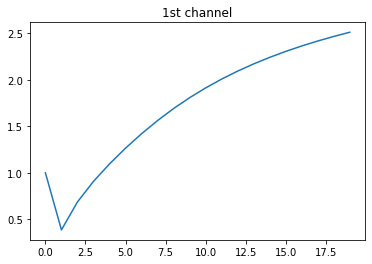

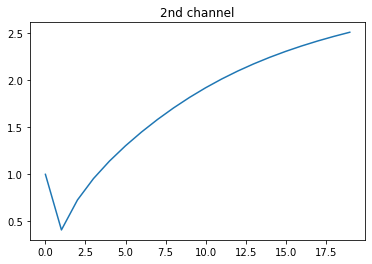

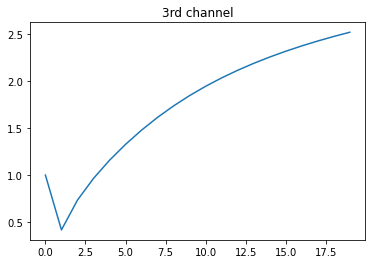

In [ ]:
import matplotlib.pyplot as plt

channel1_ls, channel2_ls, channel3_ls = [], [], []
for p in range(20) :
  gem_pooling = GeM(p = p)
  channel1, channel2, channel3 = gem_pooling(random_tensor).flatten()
  channel1_ls.append(channel1.detach().numpy())
  channel2_ls.append(channel2.detach().numpy())
  channel3_ls.append(channel3.detach().numpy())

plt.plot(range(20), channel1_ls)
plt.title('1st channel')
plt.show()

plt.plot(range(20), channel2_ls)
plt.title('2nd channel')
plt.show()

plt.plot(range(20), channel3_ls)
plt.title('3rd channel')
plt.show()




In [ ]:
class ArcMarginProduct(nn.Module) :
  '''Implementation of large margin arc distance 
    args :
      in_features : size of each input sample
      out_features : size of each output sample
      s : norm of input feature
      m : margin
      cos(theta + m)   
  '''

  def __init__(self, in_features, out_features, s = 30.0, m = 0.50, easy_margin = False, ls_eps = 0.0) :
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.s = s
    self.m = m
    self.ls_eps = ls_eps
    self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
    nn.init.xavier_uniform_(self.weight)

    self.easy_margin = easy_margin
    self.cos_m = math.cos(m)
    self.sin_m = math.sin(m)
    self.th = math.cos(math.pi - m)
    self.mm = math.sin(math.pi - m) * m

  def forward(self, input, label) :
    # cos(theta) & phi(theta)
    cosine = F.linear(F.normalize(input), F.normalize(self.weight))
    sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
    phi = cosine * self.cos_m - sine * self.sin_m
    if self.easy_margin :
      phi = torch.where(cosine > 0, phi, cosine)
    else :
      phi = torch.where(cosine > self.th, phi, cosine - self.mm)
    
    one_hot = torch.zeros(cosine.size(), device = CONFIG['device'])
    one_hot.scatter_(1, label.view(-1, 1).long(), 1)
    if self.ls_eps > 0 :
      one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
    # ------torch.where(out_i = {x_i if condition_i else y_i})-------
    output = (one_hot * phi) + ((1.0 - one_hot) * cosine )
    output *= self.s

    return output 


In [ ]:
F.normalize(torch.tensor([[1.,2.,3.,4.,5.,6.,7.]]))

tensor([[0.0845, 0.1690, 0.2535, 0.3381, 0.4226, 0.5071, 0.5916]])

In [ ]:
class HappyWhaleModel(nn.Module) :
  def __init__(self, model_name, embedding_size, pretrained = True) :
    super().__init__()
    self.model = timm.create_model(model_name, pretrained = pretrained)
    in_features = self.model.classifier.in_features
    self.model.classifier = nn.Identity()
    self.model.global_pool = nn.Identity()
    self.pooling = GeM(p = CONFIG['p'],
                       eps = CONFIG['eps'])
    self.embedding = nn.Linear(in_features, embedding_size)
    self.fc = ArcMarginProduct(embedding_size,
                               CONFIG['num_classes'],
                               s = CONFIG['s'],
                               m = CONFIG['m'],
                               easy_margin = CONFIG['ls_eps'],
                               ls_eps = CONFIG['ls_eps'])
    
  def forward(self, images, labels) :
    features = self.model(images)
    pooled_features = self.pooling(features).flatten(1)
    embedding = self.embedding(pooled_features)
    output = self.fc(embedding, labels)
    return output

  def extract(self, images) :
    features = self.model(images)
    pooled_features = self.pooling(features).flatten(1)
    embedding = self.embedding(pooled_features)
    return embedding

model = HappyWhaleModel(CONFIG['model_name'], CONFIG['embedding_size'], CONFIG['pretrained'])
model.to(CONFIG['device'])

if CONFIG['load_weight'] :
  model.load_state_dict(torch.load(CONFIG['load_weight']))

In [ ]:
def criterion(outputs, labels) :
  return nn.CrossEntropyLoss()(outputs, labels)

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch) :
  model.train()

  dataset_size = 0.0
  running_loss = 0.0

  bar = tqdm(enumerate(dataloader), total = len(dataloader))
  for step, data in bar :
    images = data['image'].to(device, dtype = torch.float)
    labels = data['label'].to(device, dtype = torch.long)

    batch_size = images.size(0)

    outputs = model(images, labels)
    loss = criterion(outputs, labels)
    loss = loss / CONFIG['n_accumulate']

    loss.backward()

    if (step + 1) % CONFIG['n_accumulate'] == 0 :
      optimizer.step()

      # zero the parameter gradients
      optimizer.zero_grad()

      if scheduler is not None :
        scheduler.step()

    running_loss += (loss.item() * batch_size)
    dataset_size += batch_size

    epoch_loss = running_loss / dataset_size

    bar.set_postfix(Epoch = epoch, Train_Loss = epoch_loss,
                    LR = optimizer.param_groups[0]['lr'])
    
  gc.collect()

  return epoch_loss

In [ ]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch) :
  model.eval()
  
  dataset_size = 0
  running_loss = 0.0

  bar = tqdm(enumerate(dataloader), total = len(dataloader))
  for step, data in bar :
    images = data['image'].to(device, dtype = torch.float)
    labels = data['label'].to(device, dtype = torch.long)

    batch_size = images.size(0)

    outputs = model(images, labels)
    loss = criterion(outputs, labels)

    running_loss += (loss.item() * batch_size)
    dataset_size += batch_size

    epoch_loss = running_loss / dataset_size
    
    bar.set_postfix(Epoch = epoch, Valid_Loss = epoch_loss,
                    LR = optimizer.param_groups[0]['lr'])
    
  gc.collect()
  
  return epoch_loss

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs) :

  # To automatically log gradients
  wandb.watch(model, log_freq = 100)

  if torch.cuda.is_available() :
    print('[INFO] Using GPU : {}\n'.format(torch.cuda.get_device_name()))

  start = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_epoch_loss = np.inf
  history = defaultdict(list)

  for epoch in range(1, num_epochs + 1) :
    gc.collect()
    train_epoch_loss = train_one_epoch(model, 
                                       optimizer, 
                                       scheduler, 
                                       dataloader = train_loader, 
                                       device = CONFIG['device'], 
                                       epoch = epoch)
    val_epoch_loss = valid_one_epoch(model,
                                     valid_loader,
                                     device = CONFIG['device'],
                                     epoch = epoch
                                     )
    history['Train Loss'].append(train_epoch_loss)
    history['Valid Loss'].append(val_epoch_loss)

    # Log the metrics
    wandb.log({'Train Loss' : train_epoch_loss})
    wandb.log({'Valid Loss' : val_epoch_loss})

    # deep copy the model
    if val_epoch_loss <= best_epoch_loss :
      print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
      best_epoch_loss = val_epoch_loss
      run.summary['Best Loss'] = best_epoch_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      PATH = os.path.join(ROOT_DIR, 'Loss{:.4f}_epoch{:.0f}.bin'.format(best_epoch_loss, epoch))
      torch.save(model.state_dict(), PATH)
      # Save a model file from the current directory
      print(f"Model Saved{sr_}")

    print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed//3600, (time_elapsed%3600) // 60, (time_elapsed % 3600) % 60
    ))
    print('Best Loss: {:.4f}'.format(best_epoch_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

  return model, history


In [ ]:
def fetch_scheduler(optimizer) :
  if CONFIG['scheduler'] == 'CosineAnnealingLR' :
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = CONFIG['T_max'], eta_min = CONFIG['min_lr'])
  elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts' :
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = CONFIG['T_0'], eta_min = CONFIG['min_lr'] )
  elif CONFIG['scheduler'] == None :
    return None

  return scheduler

In [ ]:
def prepare_loaders(df, fold) :
  df_train = df[df.fold != fold].reset_index( drop = True)
  df_valid = df[df.fold == fold].reset_index( drop = True)

  train_dataset = HappyWhaleDataset(df_train, transforms = data_transforms['train'])
  valid_dataset = HappyWhaleDataset(df_valid, transforms = data_transforms['valid'])

  train_loader = DataLoader(train_dataset, batch_size = CONFIG['train_batch_size'], num_workers = 4, shuffle = True, pin_memory = True, drop_last = True)
  valid_loader = DataLoader(valid_dataset, batch_size = CONFIG['valid_batch_size'], num_workers = 4, shuffle = False, pin_memory = True, drop_last = True)

  return train_loader, valid_loader

In [ ]:
train_loader, valid_loader = prepare_loaders(df, fold = 1)

In [ ]:

optimizer = optim.Adam(model.parameters(), 
                       lr = CONFIG['learning_rate'],
                       weight_decay = CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

In [ ]:
run = wandb.init(project = 'HappyWhale_ArcFace+GeM',
                 config = CONFIG,
                 job_type = 'Train',
                 tags = ['arcface', 'gem-pooling', 'effnet-b0-ns', '448'],
                  anonymous = 'must')

Problem at: <ipython-input-47-2afc6ddbb284> 5 <module>


KeyboardInterrupt: ignored

[I 2022-04-06 14:58:33,859] A new study created in memory with name: no-name-209fd14d-84b6-4c9c-a9ca-eaffc120937c


KeyError: ignored

In [ ]:
# optuna objective
def objective(trial, model = model, optimizer  = optimizer, scheduler = optimizer) :
  CONFIG = dict(seed = 2022,
              epochs = 300,
              img_size = 448,
              model_name = 'tf_efficientnet_b0_ns',
              num_classes = 15587,
              embedding_size = 512,
              pretrained = trial.suggest_categorical('pretrianed', [ True, False]),
              train_batch_size = 32,
              valid_batch_size = 64,
              learning_rate = 1e-5,
              scheduler= 'CosineAnnealingLR',
              min_lr = 1e-6,
              load_weight = '/content/drive/MyDrive/Colab Notebooks/Loss13.7009_epoch8.bin',
              T_max_freq = trial.suggest_int('T_max_freq', 3, 10),
              weight_decay = 1e-6,
              n_fold = 5,
              n_accumulate = 1,
              device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
              # GeM Hyperparameters
              p = 3,
              eps = 1e-6,
              # ArcFace Hyperparameters
              s = 30.0,
              m = 0.50,
              ls_eps = 0.0,
              easy_margin = False,
               )
  
  CONFIG['T_max'] = CONFIG['epochs'] // CONFIG['T_max_freq']
  # if not pretrained, no loading weight
  if not CONFIG['pretrained'] :
    CONFIG['load_weight'] = ''
  pretrained_str = 'pretrained' if CONFIG['pretrained'] else 'vanilla'
  experiment_name = f'{pretrained_str}_T_max{CONFIG["T_max"]}'
  
  os.makedirs(os.path.join(ROOT_DIR, experiment_name), exist_ok = True)

  run = wandb.init(project = 'HappyWhale_ArcFace+GeM',
                   name = f'{experiment_name}',
                   config = CONFIG,
                   reinit = True,
                   anonymous = 'must')


  # To automatically log gradients
  wandb.watch(model, log_freq = 100)

  if torch.cuda.is_available() :
    print('[INFO] Using GPU : {}\n'.format(torch.cuda.get_device_name()))

  start = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_epoch_loss = np.inf
  history = defaultdict(list)

  for epoch in range(1, CONFIG['epochs'] + 1) :
    gc.collect()
    train_epoch_loss = train_one_epoch(model, 
                                       optimizer, 
                                       scheduler, 
                                       dataloader = train_loader, 
                                       device = CONFIG['device'], 
                                       epoch = epoch)
    val_epoch_loss = valid_one_epoch(model,
                                     valid_loader,
                                     device = CONFIG['device'],
                                     epoch = epoch
                                     )
    history['Train Loss'].append(train_epoch_loss)
    history['Valid Loss'].append(val_epoch_loss)

    # Log the metrics
    wandb.log({'Train Loss' : train_epoch_loss})
    wandb.log({'Valid Loss' : val_epoch_loss})

    # deep copy the model
    if val_epoch_loss <= best_epoch_loss :
      print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
      best_epoch_loss = val_epoch_loss
      run.summary['Best Loss'] = best_epoch_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      PATH = os.path.join(ROOT_DIR, experiment_name, 'Loss{:.4f}_epoch{:.0f}.bin'.format(best_epoch_loss, epoch))
      torch.save(model.state_dict(), PATH)
      # Save a model file from the current directory
      print(f"Model Saved{sr_}")

    trial.report(val_epoch_loss, step = epoch)
    if trial.should_prune() :
      raise optuna.TrialPruned()


    print()

  end = time.time()
  time_elapsed = end - start
  print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
      time_elapsed//3600, (time_elapsed%3600) // 60, (time_elapsed % 3600) % 60
  ))
  print('Best Loss: {:.4f}'.format(best_epoch_loss))

  # load best model weights
  model.load_state_dict(best_model_wts)

  return history['Valid Loss']


In [ ]:
import joblib
from optuna.trial import TrialState


study = optuna.create_study(direction = 'minimize', sampler = optuna.samplers.TPESampler())

timeout = 24 * 60 * 60 * 2 # seconds -> 2 days ?
study.optimize(objective, timeout = timeout, show_progress_bar = True )

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print('Number of finished trials: ', len(study.trials))

print('Best trial:')
trial = study.best_trial

print('  Value: ', trial.value)

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
study.trials_dataframe().sort_values(["value"],ascending = False)

x0 = []
y0 = []
for i in range(len(study.get_trials())) :
    check = study.get_trials()[i].value
    if check is None :
        continue
    x0.append(list(study.get_trials()[i].params.values()))
    y0.append(study.get_trials()[i].value)


summary = wandb.init(project="HappyWhale_ArcFace+GeM",
                         name="summary",
                         job_type="logging")

# Getting the study trials.
trials = study.trials

# WandB summary.
for step, trial in enumerate(trials):
    # Logging the loss.
    summary.log({"valid loss": trial.value}, step=step)

    # Logging the parameters.
    for k, v in trial.params.items():
        summary.log({k: v}, step=step)

joblib.dump(study, os.path.join(ROOT_DIR, 'optuna_study.pkl'))



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model, history = run_training(model, optimizer, scheduler,
                              device = CONFIG['device'],
                              num_epochs = CONFIG['epochs'])

[INFO] Using GPU : Tesla P100-PCIE-16GB



100%|██████████| 159/159 [00:44<00:00,  3.58it/s, Epoch=1, LR=4.8e-6, Valid_Loss=13.9]


Validation Loss Improved (inf ---> 13.9476228869936)
Model Saved

Training complete in 0h 11m 50s
Best Loss: 13.9476


100%|██████████| 159/159 [00:44<00:00,  3.56it/s, Epoch=2, LR=1.22e-6, Valid_Loss=13.9]


Validation Loss Improved (13.9476228869936 ---> 13.937741525518069)
Model Saved

Training complete in 0h 23m 41s
Best Loss: 13.9377


100%|██████████| 159/159 [00:44<00:00,  3.59it/s, Epoch=3, LR=7.54e-6, Valid_Loss=14]



Training complete in 0h 35m 30s
Best Loss: 13.9377


100%|██████████| 159/159 [00:44<00:00,  3.58it/s, Epoch=4, LR=9.14e-6, Valid_Loss=14]



Training complete in 0h 47m 17s
Best Loss: 13.9377


100%|██████████| 159/159 [00:44<00:00,  3.56it/s, Epoch=5, LR=2.32e-6, Valid_Loss=13.9]


Validation Loss Improved (13.937741525518069 ---> 13.90860990008468)
Model Saved

Training complete in 0h 59m 4s
Best Loss: 13.9086


100%|██████████| 159/159 [00:44<00:00,  3.56it/s, Epoch=6, LR=2.85e-6, Valid_Loss=13.9]


Validation Loss Improved (13.90860990008468 ---> 13.864065392212298)
Model Saved

Training complete in 1h 10m 51s
Best Loss: 13.8641


100%|██████████| 159/159 [00:44<00:00,  3.58it/s, Epoch=7, LR=9.51e-6, Valid_Loss=13.9]


Validation Loss Improved (13.864065392212298 ---> 13.86063794669865)
Model Saved

Training complete in 1h 22m 40s
Best Loss: 13.8606


100%|██████████| 159/159 [00:44<00:00,  3.53it/s, Epoch=8, LR=6.89e-6, Valid_Loss=13.7]


Validation Loss Improved (13.86063794669865 ---> 13.70087479045556)
Model Saved

Training complete in 1h 34m 28s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.57it/s, Epoch=9, LR=1.06e-6, Valid_Loss=13.8]



Training complete in 1h 46m 16s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.56it/s, Epoch=10, LR=5.5e-6, Valid_Loss=13.8]



Training complete in 1h 58m 5s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.56it/s, Epoch=11, LR=9.94e-6, Valid_Loss=13.7]



Training complete in 2h 9m 53s
Best Loss: 13.7009


100%|██████████| 159/159 [00:45<00:00,  3.53it/s, Epoch=12, LR=4.11e-6, Valid_Loss=13.8]



Training complete in 2h 21m 42s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.57it/s, Epoch=13, LR=1.49e-6, Valid_Loss=13.8]



Training complete in 2h 33m 30s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.54it/s, Epoch=14, LR=8.15e-6, Valid_Loss=13.9]



Training complete in 2h 45m 17s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.58it/s, Epoch=15, LR=8.68e-6, Valid_Loss=13.8]



Training complete in 2h 57m 4s
Best Loss: 13.7009


100%|██████████| 159/159 [00:45<00:00,  3.53it/s, Epoch=16, LR=1.86e-6, Valid_Loss=13.8]



Training complete in 3h 8m 54s
Best Loss: 13.7009


100%|██████████| 159/159 [00:45<00:00,  3.52it/s, Epoch=17, LR=3.46e-6, Valid_Loss=13.8]



Training complete in 3h 20m 47s
Best Loss: 13.7009


100%|██████████| 159/159 [00:45<00:00,  3.52it/s, Epoch=18, LR=9.78e-6, Valid_Loss=13.9]



Training complete in 3h 32m 40s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.56it/s, Epoch=19, LR=6.2e-6, Valid_Loss=13.9]



Training complete in 3h 44m 28s
Best Loss: 13.7009


100%|██████████| 159/159 [00:45<00:00,  3.53it/s, Epoch=20, LR=1e-6, Valid_Loss=13.8]



Training complete in 3h 56m 15s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.56it/s, Epoch=21, LR=6.2e-6, Valid_Loss=13.8]



Training complete in 4h 8m 4s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.57it/s, Epoch=22, LR=9.78e-6, Valid_Loss=13.7]



Training complete in 4h 19m 51s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.56it/s, Epoch=23, LR=3.46e-6, Valid_Loss=13.8]



Training complete in 4h 31m 38s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.59it/s, Epoch=24, LR=1.86e-6, Valid_Loss=13.8]



Training complete in 4h 43m 22s
Best Loss: 13.7009


100%|██████████| 159/159 [00:45<00:00,  3.48it/s, Epoch=25, LR=8.68e-6, Valid_Loss=13.8]



Training complete in 4h 55m 6s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.58it/s, Epoch=26, LR=8.15e-6, Valid_Loss=13.8]



Training complete in 5h 6m 50s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.57it/s, Epoch=27, LR=1.49e-6, Valid_Loss=13.8]



Training complete in 5h 18m 36s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.58it/s, Epoch=28, LR=4.11e-6, Valid_Loss=13.9]



Training complete in 5h 30m 22s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.55it/s, Epoch=29, LR=9.94e-6, Valid_Loss=13.8]



Training complete in 5h 42m 8s
Best Loss: 13.7009


100%|██████████| 159/159 [00:44<00:00,  3.55it/s, Epoch=30, LR=5.5e-6, Valid_Loss=13.8]



Training complete in 5h 53m 55s
Best Loss: 13.7009
